<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/DR-stage-identification/DR_Classification_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Defining dataset paths and splitting

In [ ]:
# Define paths
base_path = "/content/drive/My Drive/DR_StageClassification_Final"
csv_path = os.path.join(base_path, "dataset.csv")
dataset_folder = os.path.join(base_path, "Dataset")

In [ ]:
# Load CSV
df = pd.read_csv(csv_path)

In [ ]:
# Split dataset (80:10:10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['diagnosis'], random_state=42)

# Print dataset sizes
print(f"Training samples: {len(train_df)}, Validation samples: {len(valid_df)}, Testing samples: {len(test_df)}")

Training samples: 4032, Validation samples: 504, Testing samples: 505


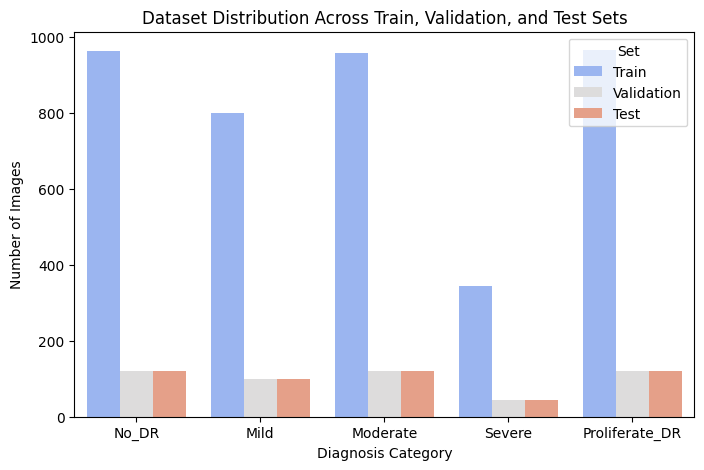

In [ ]:
# Visualizing dataset distribution
fig, ax = plt.subplots(figsize=(8, 5))

# Get value counts for each set
data_counts = {
    "Train": train_df['diagnosis'].value_counts().sort_index(),
    "Validation": valid_df['diagnosis'].value_counts().sort_index(),
    "Test": test_df['diagnosis'].value_counts().sort_index()
}

# Convert to DataFrame and reshape for Seaborn
df_vis = pd.DataFrame(data_counts).reset_index(names=['Diagnosis']).melt(id_vars=['Diagnosis'], var_name='Set', value_name='Count')

# Plot using seaborn
sns.barplot(x='Diagnosis', y='Count', hue='Set', data=df_vis, palette="coolwarm", ax=ax)

# Set proper labels and title
ax.set_xticks(range(5))  # Ensure correct positioning
ax.set_xticklabels(["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"])
ax.set_xlabel("Diagnosis Category")
ax.set_ylabel("Number of Images")
ax.set_title("Dataset Distribution Across Train, Validation, and Test Sets")

plt.show()

## Loading Pretrained Model

In [ ]:
# Load ResNet50 Pretrained Model
def load_resnet50(input_shape=(224, 224, 3), trainability=False):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    preprocessor = tf.keras.applications.resnet50.preprocess_input
    for layer in base_model.layers:
        layer.trainable = trainability
    return base_model, preprocessor

base_model, preprocess_input = load_resnet50()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Feature Extraction

In [ ]:
# Feature extraction function
def extract_features(dataframe, dataset_folder, preprocess_input):
    features, labels = [], []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Extracting Features"):
        img_path = os.path.join(dataset_folder, f"{row['id_code']}.png")
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        features.append(base_model.predict(img_array, verbose=0).flatten())
        labels.append(row['diagnosis'])

    return np.array(features), np.array(labels)

In [ ]:
# Extract features and save
train_features, train_labels = extract_features(train_df, dataset_folder, preprocess_input)
valid_features, valid_labels = extract_features(valid_df, dataset_folder, preprocess_input)
test_features, test_labels = extract_features(test_df, dataset_folder, preprocess_input)

np.save(os.path.join(base_path, "train_features.npy"), train_features)
np.save(os.path.join(base_path, "train_labels.npy"), train_labels)
np.save(os.path.join(base_path, "valid_features.npy"), valid_features)
np.save(os.path.join(base_path, "valid_labels.npy"), valid_labels)
np.save(os.path.join(base_path, "test_features.npy"), test_features)
np.save(os.path.join(base_path, "test_labels.npy"), test_labels)

Extracting Features: 100%|██████████| 505/505 [04:00<00:00,  2.10it/s]


## Class Weights and setting up for training process

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

Computed class weights: {0: 0.8365145228215768, 1: 1.008, 2: 0.8408759124087591, 3: 2.3510204081632655, 4: 0.8347826086956521}


In [ ]:
# Define classifier model
def build_model(input_shape):
    model = models.Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# One-hot encode labels
train_labels_cat = to_categorical(train_labels, num_classes=5)
valid_labels_cat = to_categorical(valid_labels, num_classes=5)

## Model Training and saving

In [ ]:
# Train model
model = build_model(input_shape=train_features.shape[1:])
history = model.fit(train_features, train_labels_cat, epochs=30, batch_size=32, validation_data=(valid_features, valid_labels_cat), class_weight=class_weights)

# Save the model
model.save(os.path.join(base_path, "DR_StageClassification_FinalModel.h5"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4058 - loss: 34.5248 - val_accuracy: 0.4742 - val_loss: 1.1981
Epoch 2/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4872 - loss: 1.2778 - val_accuracy: 0.6687 - val_loss: 0.9797
Epoch 3/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5905 - loss: 1.1490 - val_accuracy: 0.6607 - val_loss: 1.0416
Epoch 4/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6023 - loss: 1.0976 - val_accuracy: 0.6647 - val_loss: 0.8993
Epoch 5/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6331 - loss: 0.9636 - val_accuracy: 0.6865 - val_loss: 0.8931
Epoch 6/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6352 - loss: 1.0022 - val_accuracy: 0.6548 - val_loss: 0.8995
Epoch 7/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6550 - loss: 0.8877 - val_accuracy: 0.6706 - val_loss: 0.9223
Epoch 8/30
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6570 - loss: 0.8852 - val_acc

## Model Evaluation

In [ ]:
# Evaluate the model
test_labels_cat = to_categorical(test_labels, num_classes=5)
test_loss, test_acc = model.evaluate(test_features, test_labels_cat)
print(f"Test Accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7706 - loss: 0.7578
Test Accuracy: 0.7545


In [ ]:
# Classification Report
y_pred = np.argmax(model.predict(test_features), axis=1)
print("Classification Report:\n", classification_report(test_labels, y_pred, target_names=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"]))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Classification Report:
                 precision    recall  f1-score   support

         No_DR       0.91      0.97      0.94       121
          Mild       0.65      0.81      0.72       100
      Moderate       0.68      0.68      0.68       120
        Severe       0.59      0.40      0.47        43
Proliferate_DR       0.82      0.69      0.75       121

      accuracy                           0.75       505
     macro avg       0.73      0.71      0.71       505
  weighted avg       0.75      0.75      0.75       505



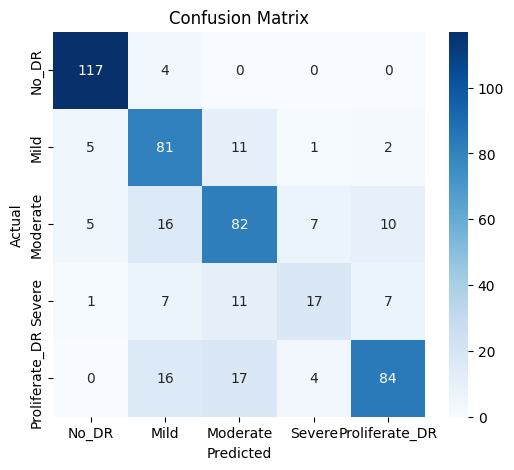

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"], yticklabels=["No_DR", "Mild", "Moderate", "Severe", "Proliferate_DR"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Actual Diagnosis: 4 - Predicted Diagnosis: 4


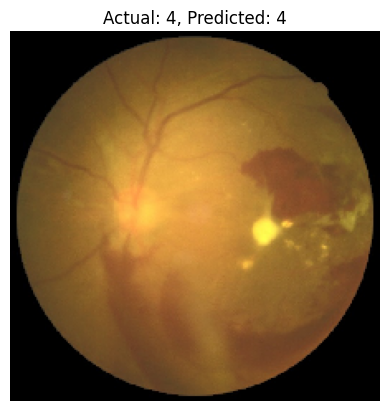

In [ ]:
# Random image prediction from test set
def test_random_image(model, test_df, dataset_folder, preprocess_input):
    random_idx = random.randint(0, len(test_df) - 1)
    img_id = test_df.iloc[random_idx]['id_code']
    actual_label = test_df.iloc[random_idx]['diagnosis']
    img_path = os.path.join(dataset_folder, f"{img_id}.png")

    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    feature = base_model.predict(img_array, verbose=0).flatten().reshape(1, -1)
    prediction = np.argmax(model.predict(feature), axis=1)[0]

    print(f"Actual Diagnosis: {actual_label} - Predicted Diagnosis: {prediction}")

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Actual: {actual_label}, Predicted: {prediction}")
    plt.show()

# Test with random image
test_random_image(model, test_df, dataset_folder, preprocess_input)